In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import random
import os

In [2]:
BATCH_SIZE = 50
N_LAYERS = 3
TEST_SIZE = 0.2
TEACHER_FORCING = 0.5
RANDOM_STATE = 666
EPOCHS = 10
LR = 0.001
N_EMBED = 64
HEAD_SIZE = 64
MAX_SEQ_LEN = 50
N_HEADS = 4
DROPOUT = 0.2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

SIGNS = '.,?!:; '
NUMBERS = ''.join([str(i) for i in range(10)])
RUSSIAN_LETTERS_AND_SIGNS = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя' + SIGNS + NUMBERS
ENGLISH_LETTERS_AND_SIGNS = ''.join([chr(i) for i in range(ord('a'), ord('z') + 1)]) + SIGNS + NUMBERS

SOS_TOKEN = "<sos>" 
EOS_TOKEN = "<eos>" 
UNK_TOKEN = "<unk>" 
PAD_TOKEN = "<pad>" 

DATA_FOLDER = Path('data')
MODELS_PATH = Path('models')
X_TRAIN_PATH = DATA_FOLDER / 'en_train.txt'
Y_TRAIN_PATH = DATA_FOLDER / 'ru_train.txt'
X_TEST_PATH = DATA_FOLDER / 'en_valid.txt'
Y_TEST_PATH = DATA_FOLDER / 'ru_valid.txt'
FULL_DATA_PATH = DATA_FOLDER / 'data.txt'

### **GET DATA**

In [3]:
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)

if not os.path.exists(DATA_FOLDER):
    os.mkdir(DATA_FOLDER)

In [4]:
! wget -O FULL_DATA_PATH https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 

In [5]:
class FileTokenizer:
    def __init__(self,
                 path: str,
                 sos_token: str = SOS_TOKEN,
                 eos_token: str = EOS_TOKEN,
                 pad_token: str = PAD_TOKEN,
                 unk_token: str = UNK_TOKEN):
        '''Tokenize data from the file by path'''
        
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.unk_token = unk_token

        input_file = open(path)
        self.texts = input_file.read()
        input_file.close()

        self.create_tokenizer()
        
    @staticmethod
    def clean_text(text: str):
        return text.lower().strip()

    def create_tokenizer(self):
        self.texts = self.clean_text(self.texts)
        texts = set(self.texts.replace('\n', ''))

        self.tokens = [char for char in texts if char in ENGLISH_LETTERS_AND_SIGNS or char in RUSSIAN_LETTERS_AND_SIGNS]
        self.tokens += [self.sos_token, self.eos_token, self.pad_token, self.unk_token]

        self.char2ind = {char: ind for ind, char in enumerate(self.tokens)}
        self.ind2char = {ind: char for ind, char in enumerate(self.tokens)}

    def convert_tokens_to_ind(self, text: str):
        text = [char.lower() for char in text]
        result = [self.char2ind[self.sos_token]]
        result += [self.char2ind.get(char, self.char2ind[self.unk_token]) for char in text]
        result += [self.char2ind[self.eos_token]]
        
        return result
    
    def convert_ind_to_token(self, text: list):

        result = [self.ind2char.get(int(char.item()), self.unk_token) for char in text]

        return result
    
    def tokenize(self, text):
        '''Return list tokenized sequences from file'''
        return self.convert_tokens_to_ind(text)

        

In [6]:
split_lines = []

with open(FULL_DATA_PATH) as file:
    split_lines += [line.strip().split('\t') for line in file.readlines()]

en_lines = [line[0] for line in split_lines]
ru_lines = [line[1] for line in split_lines]

en_train_texts, en_test_texts, ru_train_texts, ru_test_texts = train_test_split(en_lines, 
                                                                                ru_lines, 
                                                                                test_size=TEST_SIZE, 
                                                                                random_state=RANDOM_STATE, 
                                                                                shuffle=True )

with open(X_TRAIN_PATH, 'w') as f:
    f.write('\n'.join(en_train_texts))

with open(Y_TRAIN_PATH, 'w') as f:
    f.write('\n'.join(ru_train_texts))

with open(X_TEST_PATH, 'w') as f:
    f.write('\n'.join(en_test_texts))

with open(Y_TEST_PATH, 'w') as f:
    f.write('\n'.join(ru_test_texts))

In [7]:
class TranslationDataset(Dataset):
    def __init__(self,
                 X_path: str,
                 X_tokenizer: FileTokenizer,
                 X_len: int,
                 y_path: str,
                 y_tokenizer: FileTokenizer,
                 y_len: int,
                 is_train: bool = False):
        
        self.is_train = is_train

        with open(X_path) as file:
            self.X = [line.strip() for line in file.readlines()]

        if self.is_train:
            with open(y_path) as file:
                self.y = [line.strip() for line in file.readlines()]

        self.X_tokenizer = X_tokenizer
        self.y_tokenizer = y_tokenizer

        self.X_len = X_len
        self.y_len = y_len

    def __getitem__(self, ind):

        X_pads = [self.X_tokenizer.pad_token] * max(0, self.X_len - len(self.X[ind]))
        X_tokenized = self.X_tokenizer.tokenize(list(self.X[ind][:self.X_len]) + X_pads)

        if self.is_train:
            y_pads = [self.y_tokenizer.pad_token] * max(0, self.y_len - len(self.y[ind]))
            y_tokenized = self.y_tokenizer.tokenize(list(self.y[ind][:self.y_len]) + y_pads)
            return torch.LongTensor(X_tokenized), torch.LongTensor(y_tokenized)
        
        return torch.LongTensor(X_tokenized)
    
    def __len__(self):
        return len(self.X)

In [8]:
en_tokenizer = FileTokenizer(X_TRAIN_PATH)
ru_tokenizer = FileTokenizer(Y_TRAIN_PATH)

train_dataset = TranslationDataset(X_path=X_TRAIN_PATH,
                                   X_tokenizer=en_tokenizer,
                                   X_len=MAX_SEQ_LEN - 2,
                                   y_path=Y_TRAIN_PATH,
                                   y_tokenizer=ru_tokenizer,
                                   y_len=MAX_SEQ_LEN - 2,
                                   is_train=True)

test_dataset = TranslationDataset(X_path=X_TEST_PATH,
                                  X_tokenizer=en_tokenizer,
                                  X_len=MAX_SEQ_LEN - 2,
                                  y_path=Y_TEST_PATH,
                                  y_tokenizer=ru_tokenizer,
                                  y_len=MAX_SEQ_LEN - 2,
                                  is_train=False)

In [9]:
len(train_dataset)

40000

In [10]:
''.join(en_tokenizer.convert_ind_to_token(train_dataset[0][0]))

'<sos>there is a mini shopping mall 150 metres from th<eos>'

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
X_test_batch = list(iter(train_dataloader))[0][0].to(DEVICE)
y_test_batch = list(iter(train_dataloader))[0][1].to(DEVICE)

In [13]:
X_test_batch.shape, y_test_batch.shape 

(torch.Size([50, 50]), torch.Size([50, 50]))

In [14]:
RU_TOKENS_LEN = len(ru_tokenizer.char2ind)
EN_TOKENS_LEN = len(en_tokenizer.char2ind)

### **CREATE TRANSFORMER**

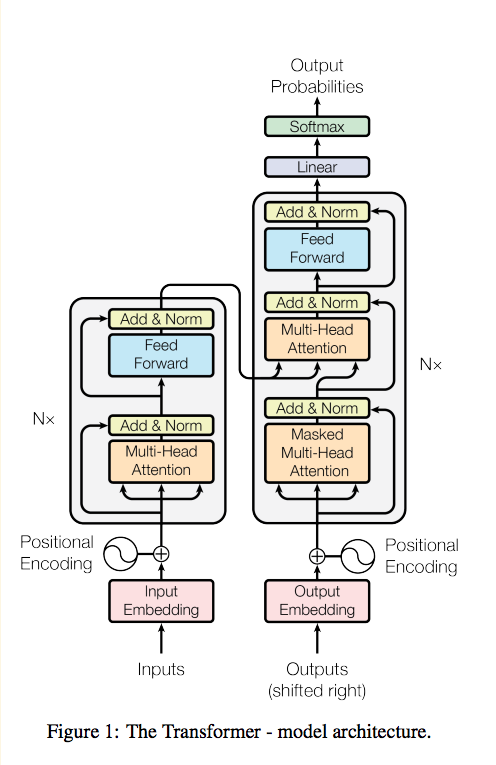

In [15]:
class SelfAttention(nn.Module):
    def __init__(self, n_embed=N_EMBED, head_size=HEAD_SIZE):
        super().__init__()
        
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)

        self.dropout = nn.Dropout(DROPOUT)


    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x) #(B, T, head_size)
        k = self.key(x) #(B, T, head_size)

        w = q @ k.transpose(-2, -1) * C ** -0.5 #(B, T, T)
        w = w.softmax(-1)
        
        v = self.value(x) #(B, T, C)
        out = w @ v #(B, T, C)

        return out

att = SelfAttention()

x = torch.rand((32, 1, N_EMBED))
att(x).shape

torch.Size([32, 1, 64])

In [16]:
class MaskedAttention(nn.Module):
    def __init__(self, n_embed=N_EMBED, head_size=HEAD_SIZE):
        super().__init__()
        self.head_size = head_size
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(MAX_SEQ_LEN, MAX_SEQ_LEN)))

        self.dropout = nn.Dropout(DROPOUT)


    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x) #(B, T, head_size)
        k = self.key(x) #(B, T, head_size)

        w = q @ k.transpose(-2, -1) * C ** -0.5 #(B, T, T)
        w = w.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        w = w.softmax(-1)
        
        v = self.value(x) #(B, T, C)
        out = w @ v #(B, T, C)

        return out

matt = MaskedAttention()

matt(x).shape

torch.Size([32, 1, 64])

In [17]:
class CrossAttention(nn.Module):
    def __init__(self, n_embed=N_EMBED, head_size=HEAD_SIZE):
        super().__init__()
        
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)

        self.dropout = nn.Dropout(DROPOUT)


    def forward(self, xe, xd):
        B, Te, C = xe.shape
        B, Td, C = xd.shape

        q = self.query(xd) #(B, Td, head_size)
        k = self.key(xe) #(B, Te, head_size)

        w = q @ k.transpose(-2, -1) * C ** -0.5 #(B, Td, Te)
        w = w.softmax(-1)

        v = self.value(xe) #(B, Te, head_size)

        out = w @ v #(B, Td, head_size)

        return out
    
catt = CrossAttention()

xe = torch.randn((4, 8, N_EMBED))
xd = torch.randn((4, 3, N_EMBED))

catt(xe, xd).shape

torch.Size([4, 3, 64])

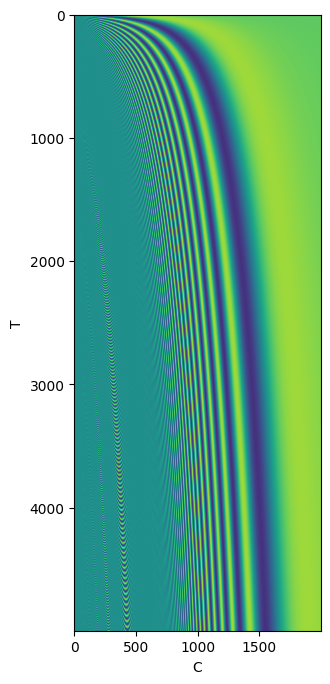

In [18]:
pos_embed = torch.zeros((5000, 2000))

pos_range = torch.stack([i / (10000 ** ((torch.arange(1, 2000 + 1) // 2) * 2 / 2000 )) for i in range(1, 5000 + 1)])
pos_embed[:, ::2] = torch.sin(pos_range[:, ::2])
pos_embed[:, 1::2] = torch.cos(pos_range[:, 1::2])

plt.figure(figsize=(10, 8)) 
plt.imshow(pos_embed.numpy())
plt.ylabel('T')
plt.xlabel('C')
plt.show()

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len=MAX_SEQ_LEN * 2, n_embed=N_EMBED):
        super().__init__()
        pos_embed = torch.zeros((max_len, n_embed))

        pos_range = torch.stack([i / (10000 ** ((torch.arange(1, n_embed + 1) // 2) * 2 / N_EMBED )) for i in range(1, max_len + 1)])
        pos_embed[:, ::2] = torch.sin(pos_range[:, ::2])
        pos_embed[:, 1::2] = torch.cos(pos_range[:, 1::2])
        self.register_buffer('pos_embed', pos_embed)

        self.dropout = nn.Dropout(DROPOUT)


    def forward(self, x):
        B, T, C = x.shape
        return x + self.pos_embed[:T, :C]
    
pos = PositionalEncoding()
pos(x).shape

torch.Size([32, 1, 64])

In [20]:
class SelfMultiHeadAttention(nn.Module):
    def __init__(self, n_embed=N_EMBED, n_heads=N_HEADS):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttention(head_size=n_embed // n_heads) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embed, n_embed)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], -1)
        out = self.proj(out)
        return out
    
mhsa = SelfMultiHeadAttention()
x = torch.randn((32, 1, N_EMBED))
mhsa(x).shape

torch.Size([32, 1, 64])

In [21]:
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, n_embed=N_EMBED, n_heads=N_HEADS):
        super().__init__()
        self.heads = nn.ModuleList([MaskedAttention(head_size=n_embed // n_heads) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embed, n_embed)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], -1)
        out = self.proj(out)
        return out
mhma = MaskedMultiHeadAttention()
mhma(x).shape

torch.Size([32, 1, 64])

In [22]:
class CrossMultiHeadAttention(nn.Module):
    def __init__(self, n_embed=N_EMBED, n_heads=N_HEADS):
        super().__init__()
        self.heads = nn.ModuleList([CrossAttention(head_size=n_embed // n_heads) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embed, n_embed)

    def forward(self, xe, xd):
        out = torch.cat([head(xe, xd) for head in self.heads], -1)
        out = self.proj(out)
        return out
mhca = CrossMultiHeadAttention()
xe = torch.randn((32, 100, N_EMBED))
xd = torch.randn((32, 1, N_EMBED))
mhca(xe, xd).shape

torch.Size([32, 1, 64])

In [23]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim=N_EMBED):
        super().__init__()

        self.fdfw = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(DROPOUT)
        )

    def forward(self, x):
        return self.fdfw(x)
fwfd = FeedForward()
fwfd(x).shape

torch.Size([32, 1, 64])

In [24]:
class EncoderBlock(nn.Module):
    def __init__(self, n_embed=N_EMBED, vocab_size=EN_TOKENS_LEN, n_heads=N_HEADS, head_size=HEAD_SIZE, max_seq_len=MAX_SEQ_LEN):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embed)
        self.mhsa = SelfMultiHeadAttention(n_embed, n_heads)

        self.ln2 = nn.LayerNorm(n_embed)
        self.fdfw = FeedForward(n_embed)

    def forward(self, x):
        out = x + self.mhsa(self.ln1(x))
        out = out + self.fdfw(self.ln2(out))
        return out

enc = EncoderBlock().to(DEVICE)
x = torch.randn((32, 100, N_EMBED)).to(DEVICE)
enc(x).shape

torch.Size([32, 100, 64])

In [25]:
class DecoderBlock(nn.Module):
    def __init__(self, n_embed=N_EMBED, vocab_size=RU_TOKENS_LEN, n_heads=N_HEADS, head_size=HEAD_SIZE, max_seq_len=MAX_SEQ_LEN):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embed)
        self.mhma = MaskedMultiHeadAttention(n_embed, n_heads)

        self.mhca = CrossMultiHeadAttention(n_embed, n_heads)
        self.ln2 = nn.LayerNorm(n_embed)
        self.ln3 = nn.LayerNorm(n_embed)

        self.ln4 = nn.LayerNorm(n_embed)
        self.fdfw = FeedForward(n_embed)

    def forward(self, xe, xd):
        out = xd + self.mhma(self.ln1(xd))
        out = out + self.mhca(self.ln2(xe), self.ln3(out))
        out = out + self.fdfw(self.ln4(out))
        return out

dec = DecoderBlock().to(DEVICE)
xe = enc(torch.randn((32, 100, N_EMBED)).to(DEVICE))
xd = torch.randn((32, 1, N_EMBED)).to(DEVICE)
dec(xe, xd).shape

torch.Size([32, 1, 64])

In [26]:
class Transformer(nn.Module):
    def __init__(self,
                 head_size=HEAD_SIZE,
                 n_head=N_HEADS,
                 num_encoder_layers=N_LAYERS,
                 num_decoder_layers=N_LAYERS,
                 dropout=DROPOUT):
        super().__init__()

        self.encoders = nn.ModuleList([EncoderBlock(n_heads=n_head) for _ in range(num_encoder_layers)])
        self.decoders = nn.ModuleList([DecoderBlock(n_heads=n_head) for _ in range(num_decoder_layers)])

    def forward(self, x, y):
        encoded = self.encoders[0](x).unsqueeze(0)
        for enc in self.encoders[1:]:
            encoded = torch.cat([encoded, enc(encoded[-1]).unsqueeze(0)], 0)

        decoded = self.decoders[0](encoded[0], y)
        for ind, dec in enumerate(self.decoders[1:]):
            decoded = dec(encoded[ind], decoded)
        
        return decoded

In [ ]:
class Translator(nn.Module):
    def __init__(self, 
                 n_embed=N_EMBED,
                 n_heads=N_HEADS,
                 n_layers=N_LAYERS,
                 enc_vocab_size=EN_TOKENS_LEN,
                 dec_vocab_size=RU_TOKENS_LEN,
                 head_size=HEAD_SIZE, 
                 max_seq_len=MAX_SEQ_LEN,
                 dropout=DROPOUT):
        super().__init__()

        self.enc_embed = nn.Embedding(enc_vocab_size, n_embed)
        self.enc_pos_embed = PositionalEncoding(max_seq_len, n_embed)
        
        self.trans = Transformer(head_size, n_heads, n_layers, n_layers, dropout)

        self.dec_embed = nn.Embedding(dec_vocab_size, n_embed)
        self.dec_pos_embed = PositionalEncoding(max_seq_len, n_embed)
        

        self.classifier = nn.Sequential(
            nn.Linear(n_embed, dec_vocab_size)
        )
    
    def forward(self, x, y):
        x_emb = self.enc_embed(x) + self.enc_pos_embed(self.enc_embed(x))
        y_emb = self.dec_embed(y) + self.dec_pos_embed(self.dec_embed(y))

        out = self.trans(x_emb, y_emb)
        
        return self.classifier(out)
        


model = Translator().to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=en_tokenizer.char2ind[PAD_TOKEN])
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
model(X_test_batch, y_test_batch).shape

torch.Size([50, 50, 80])

In [31]:
# train 
model.train()
for i in range(1, 5 + 1):
    first = 1
    loss_sum = 0
    for X, y in tqdm(train_dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        if first:
            first = 0
            print(f'PRED - {''.join(ru_tokenizer.convert_ind_to_token(model(X[0].unsqueeze(0), y[0].unsqueeze(0)).softmax(-1).argmax(-1).squeeze(0)))}')
            print(f'ANS  - {''.join(ru_tokenizer.convert_ind_to_token(y[0]))}')
        y_pred = model(X, y[:, :-1])
        B, T, C = y_pred.shape
        loss = loss_fn(y_pred.reshape(B * T, C), y[:, 1:].reshape(-1))
        loss_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch - {i} loss - {loss_sum / len(list(train_dataloader))}')

  0%|          | 3/800 [00:00<00:34, 23.39it/s]

PRED - c, clgcnlмчрc:kllicмcyl:мcg ylcyclpycмcycрgyiwc4p<unk>
ANS  - <sos>для гостей обустроена бесплатная частная парковк<eos>


100%|██████████| 800/800 [00:16<00:00, 49.22it/s]


epoch - 1 loss - 1.865641340315342


  0%|          | 2/800 [00:00<00:48, 16.59it/s]

PRED - вакже востим оредоагаютса басветены  писаресспле<eos><eos>
ANS  - <sos>также гостям предлагается размещение в более про<eos>


100%|██████████| 800/800 [00:18<00:00, 43.72it/s]


epoch - 2 loss - 1.2323084688186645


  1%|          | 5/800 [00:00<00:16, 47.68it/s]

PRED - вакже в ристе удобств <unk>елевизор с плоским экрано<eos> 
ANS  - <sos>также в числе удобств телевизор с плоским экрано<eos>


100%|██████████| 800/800 [00:18<00:00, 42.97it/s]


epoch - 3 loss - 1.067553963959217


  1%|          | 5/800 [00:00<00:16, 47.97it/s]

PRED - восимо этого, в  ножнт  зодасио ти  но ратьса ве<eos> 
ANS  - <sos>помимо этого, вы можете с легкостью добраться до<eos>


100%|██████████| 800/800 [00:18<00:00, 44.02it/s]


epoch - 4 loss - 0.9883451077342034


  0%|          | 3/800 [00:00<00:34, 22.80it/s]

PRED - вреди прочих удобств о тостинал зона  ттатникомы<eos> 
ANS  - <sos>среди прочих удобств <unk> гостиная зона, спутниково<eos>


100%|██████████| 800/800 [00:19<00:00, 40.88it/s]


epoch - 5 loss - 0.9388154098391532


In [32]:
def inference(model, src_sequence, en_tokenizer, ru_tokenizer, max_len=50, device='cuda'):
    with torch.no_grad():  
        src = torch.tensor([en_tokenizer.char2ind[SOS_TOKEN]] + [en_tokenizer.char2ind[char] for char in src_sequence], device=device).unsqueeze(0)
        tgt = torch.tensor([[ru_tokenizer.char2ind['<sos>']]], device=device)
        
        for _ in range(max_len):
            output = model(src, tgt)
            next_token = output.argmax(dim=-1)[:, -1].unsqueeze(0)
            tgt = torch.cat([tgt, next_token], dim=-1)
            
            if next_token.item() == ru_tokenizer.char2ind['<eos>']:
                break
        
        tgt_sequence = ''.join([ru_tokenizer.ind2char[idx] for idx in tgt.squeeze().cpu().numpy()])
        
        return tgt_sequence

src_sequence = 'free parking is available on site.'
translated_sequence = inference(model, src_sequence, en_tokenizer, ru_tokenizer, device=DEVICE)
print(translated_sequence)

<sos>на территории обустроена бесплатна парковка и бе<eos>
